In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import time

import dpf
import dpf_toy

def to_torch(x):
    return torch.from_numpy(x.astype(np.float32)).to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

In [2]:
### Some helpers for generating data
###

observer = dpf_toy.BeaconObserver()
observer.add_beacon((5, 3), 0.2)
observer.add_beacon((22, 8), 0.5)
observer.add_beacon((12, -10), 0.5)

# Simulation
def simulate_trajectory(timesteps=100):
    dynamics = dpf_toy.RobotDynamicsModel()

    # Generate states, control inputs
    states = [np.array([0., 0., 0.])]
    
    # First control input is unuseful -- inject NaNs to make sure they're never used :)
    controls = [np.array([np.nan, np.nan])]
    for _ in range(timesteps):
        control = torch.from_numpy(np.random.uniform(
            low=[0, -0.1], high=[0.4, 0.1], size=(2,)).astype(np.float32))
        new_state = dynamics.forward(
            torch.from_numpy(states[-1][np.newaxis, np.newaxis, :].astype(np.float32)), control[np.newaxis,:], noisy=True)

        states.append(new_state[0,0].numpy())
        controls.append(control.numpy())

    # Remove initial state
    states = states

    # Generate observations from ground-truth states
    observations = observer.forward(states)

    return states, observations, controls

# Dead-reckoning
def dead_reckon(controls, initial_state=np.array([0., 0., 0.])):
    dynamics = dpf_toy.RobotDynamicsModel()

    states = [initial_state]
    for control in controls:
        new_state = dynamics.forward(
            torch.from_numpy(states[-1][np.newaxis, :].astype(np.float32)), control, noisy=False)
        states.append(new_state[0].numpy())
    
    # Remove initial state and return
    return states

# Visualization helper
def plot_trajectories(*states_list, **states_dict):
    import itertools
    plt.figure()
    for label, states in itertools.chain(states_dict.items(), enumerate(states_list)):
        if label == "particles":
            # Format for particles should be states, log_weights
            assert len(states) == 2
            states, log_weights = states
            weights = np.exp(log_weights)
            weights /= np.max(weights)
            
            rgba = np.zeros((len(weights),4))
            rgba[:,3] = weights * 0.9 + 0.1

            x = np.asarray(states).T[0]
            y = np.asarray(states).T[1]
            plt.scatter(x, y, label=label, c=rgba)
        else:
            x = np.asarray(states).T[0]
            y = np.asarray(states).T[1]
            plt.scatter(x, y, label=label)

        
    plt.legend()
    plt.show()


In [3]:
## Generate some training data
#
training_trajectories = []
for _ in range(100):
    # States, observations, controls
    s, o, u = simulate_trajectory(80)
    training_trajectories.append((np.asarray(s), np.asarray(o), np.asarray(u)))

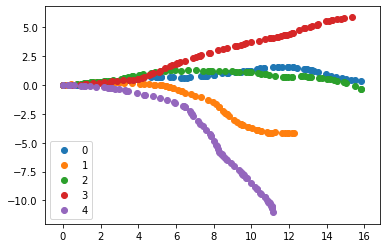

In [4]:
plot_trajectories(*[t[0] for t in training_trajectories[:5]])


In [5]:
# Initialize particle filter network
use_cuda = True #torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using device:", device)

try:
    del pfnet
    torch.cuda.empty_cache()
    print("Deleted old model!")
except:
    pass

torch.autograd.set_detect_anomaly(True)
dynamics = dpf_toy.DeepRobotDynamicsModel()
measurements = dpf_toy.DeepBeaconMeasurementModel()
# measurements = dpf_toy.BeaconMeasurementModel(observer)
pfnet = dpf.ParticleFilterNetwork(dynamics, measurements, 1.0).to(device)

Using device: cuda


In [6]:
trainset = dpf.ParticleFilterDataset(
    training_trajectories[0:1],
    subsequence_length=2,
    particle_count=100,
    particle_variances = [3, 3, 0.3]
)
trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=1)

In [7]:
print("test")

test


In [8]:
# Define optimizer
optimizer = optim.Adam(pfnet.parameters())
def train(learning_rate=1e-5, log=True):
    # Set learning rate
    # print("Setting learning rate to", learning_rate)
    for g in optimizer.param_groups:
        g['lr'] = learning_rate

    # Train for 1 epoch
    for batch_idx, batch in enumerate(trainset_loader):
        # Transfer to GPU and pull out batch data
        batch_gpu = [x.to(device) for x in batch]
        batch_particles, batch_states, batch_obs, batch_controls = batch_gpu

        # N = batch size, M = particle count
        N, timesteps, obs_dim = batch_obs.shape
        N, timesteps, control_dim = batch_controls.shape
        N, timesteps, state_dim = batch_states.shape
        N, M, state_dim = batch_particles.shape
        assert batch_obs.shape == (N, timesteps, obs_dim)
        assert batch_controls.shape == (N, timesteps, control_dim)

        # Give all particle equal weights
        particles = batch_particles
        log_weights = torch.ones((N, M), device=device) * (-np.log(M))

        for t in range(1, timesteps):
            prev_particles = particles
            prev_log_weights = log_weights

            _, new_particles, new_log_weights = pfnet.forward(
                prev_particles,
                prev_log_weights,
                batch_obs[:,t - 1,:],
                batch_controls[:,t,:],
                resample=False
            )

            
            optimizer.zero_grad()
            loss.backward(retain_graph=False)
            optimizer.step()
            assert loss.shape == ()

            particles = new_particles.detach()
            log_weights = new_log_weights.detach()

    if log:
        max_belief = torch.max(torch.exp(log_beliefs))
        print(to_numpy(loss), "\t", to_numpy(max_belief))


In [52]:
for i in range(1000):
    train(1e-3, log=(i%10 == 0))

12.242131 	 5.057481
10.498567 	 4.8382144
23.531033 	 3.6606019
-0.090326846 	 2.2827203
13.390335 	 4.7710686
13.324146 	 4.575337
12.592471 	 4.8176394
12.750667 	 4.66554
-1.2140822 	 4.766094
13.051851 	 3.3171113
13.084541 	 4.8398514
-1.1424329 	 4.9001174
12.936759 	 4.6448135
27.94685 	 5.089814
9.295139 	 5.3220077
13.352878 	 4.2578053
-1.2366818 	 5.2589946
-1.1226954 	 5.545176
-1.1420202 	 4.825485
-0.86847043 	 5.1298923
-0.35198292 	 5.107374
10.671716 	 5.2063437
-1.3459516 	 5.334451
-0.94709265 	 4.897168
12.2039175 	 5.2465653
-1.0985991 	 4.7630467
12.318936 	 4.1124053
26.613607 	 5.8851275
10.573008 	 5.0558214
13.549808 	 4.9536166
-1.0781558 	 4.378261
13.215008 	 4.8043075
12.341362 	 5.145628
25.116451 	 4.85305
-1.1429765 	 5.2975764
27.577084 	 4.1532087
-1.1121336 	 4.8428364
23.48228 	 4.9996495
-1.0628049 	 4.985373
12.89265 	 4.93915
12.631127 	 5.8949313
-1.1762605 	 5.5772514
13.572744 	 5.436129
11.845615 	 5.718593
12.829078 	 5.241749
14.222515 	 5

In [53]:
particle_states = torch.from_numpy(
    np.random.normal(0., 1., size=(1, 20, 3))
).float().to(device)
observations = torch.from_numpy(observer.forward(particle_states[0:1, 0].cpu().numpy())).float().to(device)
measurements(observations, particle_states)

tensor([[ -0.0545, -18.8766, -25.7324, -33.7271, -29.2997, -38.9869, -11.3038,
         -19.6850, -52.2440, -26.2295, -18.4480, -39.1483, -18.6127, -32.0300,
         -24.1609, -41.6175, -41.8790, -27.2453, -33.7585, -24.3533]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

In [60]:
traj_index = 0
true_states, observations, controls = training_trajectories[traj_index]
num_particles = 100

start = 0
end = start + 5

particle_states = torch.FloatTensor(
    [[true_states[start] for _ in range(num_particles)]]).to(device)

# particle_variances = [4, 4, 0.1]
# n = torch.distributions.Normal(torch.tensor([0.]), torch.tensor(particle_variances))
# particle_states += n.sample((num_particles, )).to(device)
particle_weights = torch.ones((1,num_particles)).to(device)

states = []
for control, observation in zip(controls[start + 1:end + 1], observations[start:end]):
    # Type conversions
    observation = to_torch(observation[np.newaxis,:])
    control = to_torch(control[np.newaxis,:])

    # Particle filter network: forward
    best_state, particle_states, particle_weights = pfnet.forward(
        particle_states, particle_weights, observation, control, resample=False)
    # print (np.std(particle_weights.cpu().detach().numpy()), np.mean(particle_weights.cpu().detach().numpy()))

    states.append(to_numpy(best_state))
#     print(best_state)
pf_states = np.array(states)
particle_states = particle_states[0].cpu().detach().numpy()
particle_weights = particle_weights[0].cpu().detach().numpy()

Trained network


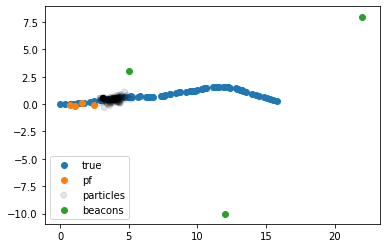

In [61]:
print("Trained network")
# print(np.exp(particle_weights))
plot_trajectories(
    true=true_states,
    pf=pf_states,
    particles=(particle_states, particle_weights),
    beacons=observer.locations
)

In [40]:
print("Trained network")
plot_trajectories(
    true=true_states,
    pf=pf_states,
    particles=(particle_states[0].cpu().numpy(), particle_weights[0].cpu().numpy()),
    beacons=observer.locations
)

Trained network


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'